In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.backtest
%aimport solvers.meanvariance
%aimport solvers.DRmeanvariance
%aimport solvers.rolling
%aimport solvers.simple

In [92]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
import factors

In [3]:
factors.famafrench.gen_three_factors()

finish loading all stock data for stock num = 1607
Market percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/market_pct_chg.pkl
finish loading all stock data for stock num = 1607
small cap percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/small_cap_portfolio_pct_ret.pkl
big cap percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/big_cap_portfolio_pct_ret.pkl
SMB percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/SMB_pct_ret.pkl
finish loading all stock data for stock num = 1607
low value percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/low_value_filter_portfolio_pct_ret.pkl
mid value percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/mid_value_filter_portfolio_pct_ret.pkl
high value percentage returns saved to:
 C:\Users\Fan\Dropbox\CMB_data_exp\ChinaA/factor_returns/high_value

In [79]:
market_pct_chg = pd.read_pickle('./factor_returns/market_pct_chg.pkl')
SMB_pct_chg = pd.read_pickle('./factor_returns/SMB_pct_ret.pkl')
HML_pct_chg = pd.read_pickle('./factor_returns/HML_pct_ret.pkl')
factors_df = pd.DataFrame({
    'market_pct_chg': market_pct_chg,
    'SMB_pct_chg': SMB_pct_chg,
    'HML_pct_chg': HML_pct_chg,
})

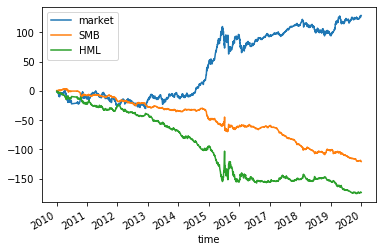

In [5]:
market_pct_chg.cumsum().plot()
SMB_pct_chg.cumsum().plot()
HML_pct_chg.cumsum().plot()
plt.legend(['market','SMB','HML'])
plt.show()

In [99]:
def resample_experiments_fama_french(exp_num, sample_stock_num, solver, **solver_kwargs):
    ts_code_generator = np.random.RandomState(42)
    info_list = ['pct_chg']
    PnL_list = []
    for exp in tqdm(range(exp_num)):
        portfolio = utils.preprocess.gen_portfolio_data_table(ts_code_generator, ['pct_chg'], 20)
        def fama_french_predicted_mean_single_stock(ts_code):
            from statsmodels.regression.rolling import RollingOLS
            # using a 400 trading day rolling window
            mod = RollingOLS(portfolio['pct_chg'][ts_code], factors_df, window = 200*2)
            rolling_params = mod.fit(params_only=True).params
            fama_french_predicted_mean = (factors_df.rolling(200*2).mean()*rolling_params).sum(axis = 1)
            return fama_french_predicted_mean
        fama_french_predicted_mean = pd.DataFrame(
            {ts_code: fama_french_predicted_mean_single_stock(ts_code) for ts_code in portfolio['pct_chg']}).values
        cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values
        training_ids = np.where((portfolio['pct_chg'].index >= '2012') & (portfolio['pct_chg'].index < '2017'))[0]
        theta_nparray = solvers.rolling.rolling_opt_framework(
            training_ids = training_ids, 
            mean_nparray = fama_french_predicted_mean, 
            cov_nparray = cov_nparray, 
            solver = solver,
            **solver_kwargs)
        theta_df = pd.DataFrame(data=theta_nparray, 
                                columns=portfolio['pct_chg'].columns, 
                                index=portfolio['pct_chg'].index)
        PnL = (theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids]
        PnL_list.append(PnL)
    PnL_table = pd.DataFrame(PnL_list).transpose()
    return PnL_table

In [100]:
PnL_table = resample_experiments_fama_french(exp_num = 50, 
                                             sample_stock_num = 20, 
                                             solver = solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel,
                                             reg_params=1)

In [104]:
PnL_table_equal_weight = utils.backtest.resample_experiments(
    exp_num = 50, 
    sample_stock_num = 20, 
    solver = solvers.simple.equal_weight, 
)

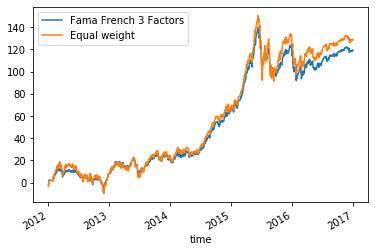

In [107]:
PnL_table.mean(axis = 1).cumsum().plot()
PnL_table_equal_weight.mean(axis = 1).cumsum().plot()
plt.legend(['Fama French 3 Factors','Equal weight'])

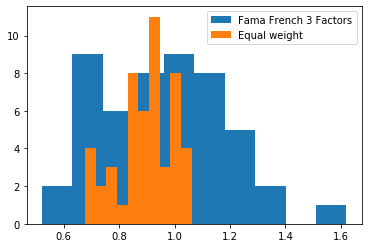

(0.9576743909637231, 0.8939426335359839)

In [115]:
plt.hist(np.sqrt(252)*PnL_table.mean() / PnL_table.std())
plt.hist(np.sqrt(252)*PnL_table_equal_weight.mean() / PnL_table_equal_weight.std())
plt.legend(['Fama French 3 Factors','Equal weight'])
plt.show()
((np.sqrt(252)*PnL_table.mean() / PnL_table.std()).mean(), 
(np.sqrt(252)*PnL_table_equal_weight.mean() / PnL_table_equal_weight.std()).mean())